In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/mt_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2003-01-01,1.0
2004-03-01,3.0
2004-07-01,1.0
2004-08-01,6.0
2004-09-01,1.0
...,...
2021-10-01,278.0
2021-11-01,267.0
2021-12-01,300.0


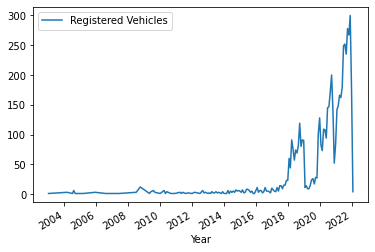

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

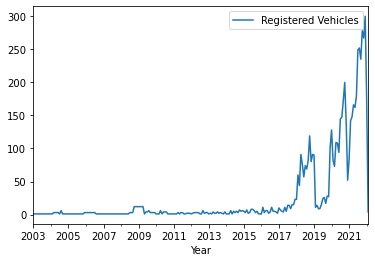

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-1.5060410241995719,
 0.5305208419932064,
 15,
 214,
 {'1%': -3.4612821203214907,
  '5%': -2.875142613826617,
  '10%': -2.574020122281422},
 1807.0728450556835)

## Modeling

In [17]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2019-12']
test = df['2020':]
combined = df

test

,Registered Vehicles
Year,
2020-01-31,128.0
2020-02-29,82.0
2020-03-31,73.0
2020-04-30,109.0
2020-05-31,108.0
2020-06-30,94.0
2020-07-31,145.0
2020-08-31,147.0
2020-09-30,172.0


In [18]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1835.496, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1529.956, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1690.005, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1521.619, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1523.403, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1523.553, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1523.732, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1521.818, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1521.675, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.489 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -757.809
Date:                Wed, 09 Nov 2022   AIC      

### The best model is :  ARIMA (2, 0, 0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6951      0.051     13.676      0.000       0.595       0.795
ar.L2          0.2655      0.051      5.249      0.000       0.166       0.365
sigma2        98.5288      2.342     42.063      0.000      93.938     103.120


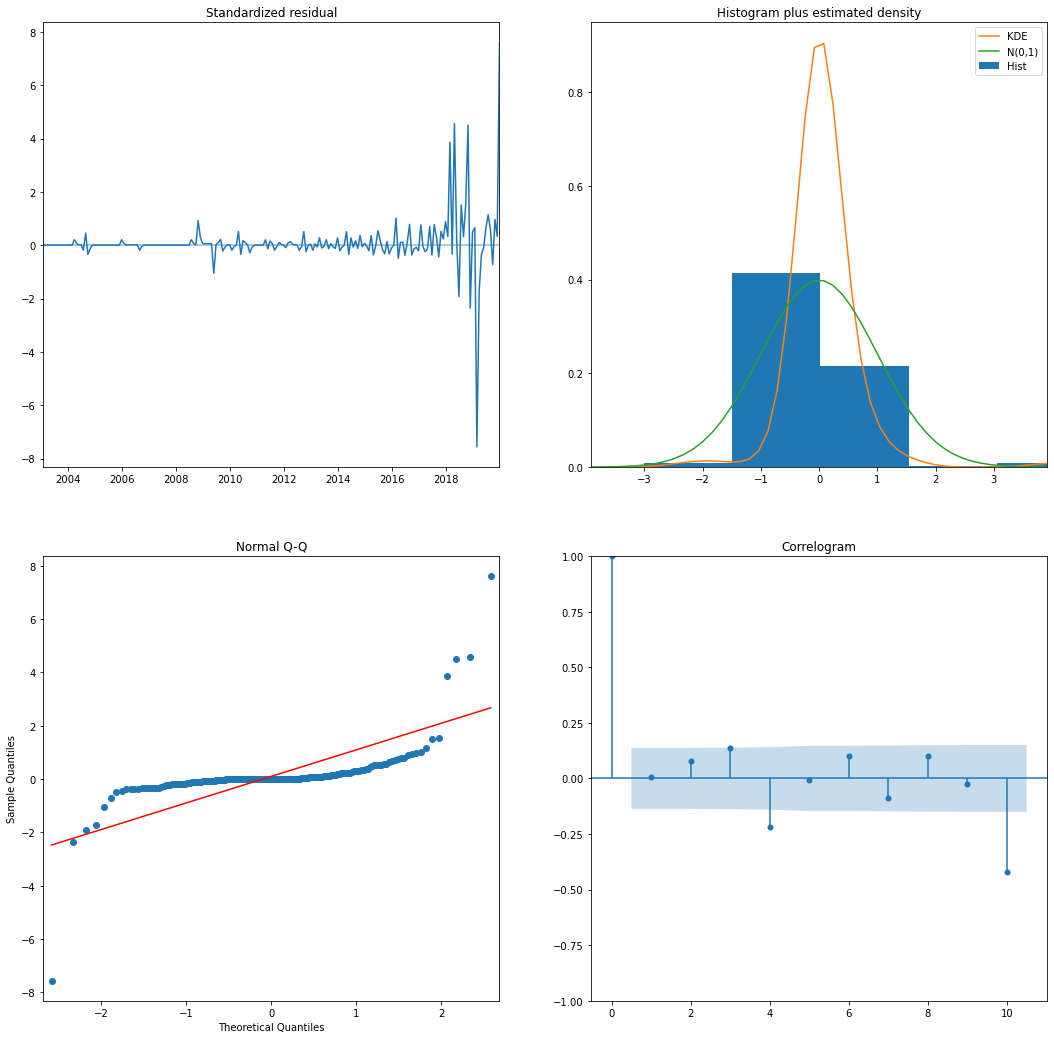

In [19]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(2,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [21]:
pred = output.get_prediction(start=pd.to_datetime('2020-01-31'), end=pd.to_datetime('2022-02-28'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-01-31,57.919627,96.829484
2020-02-29,56.908651,104.295124
2020-03-31,48.759415,104.384360
2020-04-30,43.617103,105.638083
2020-05-31,38.423650,105.988383
2020-06-30,33.824480,106.188527
2020-07-31,29.532905,106.136321
2020-08-31,25.550822,105.930955
2020-09-30,21.822580,105.595083
2020-10-31,18.321504,105.159287


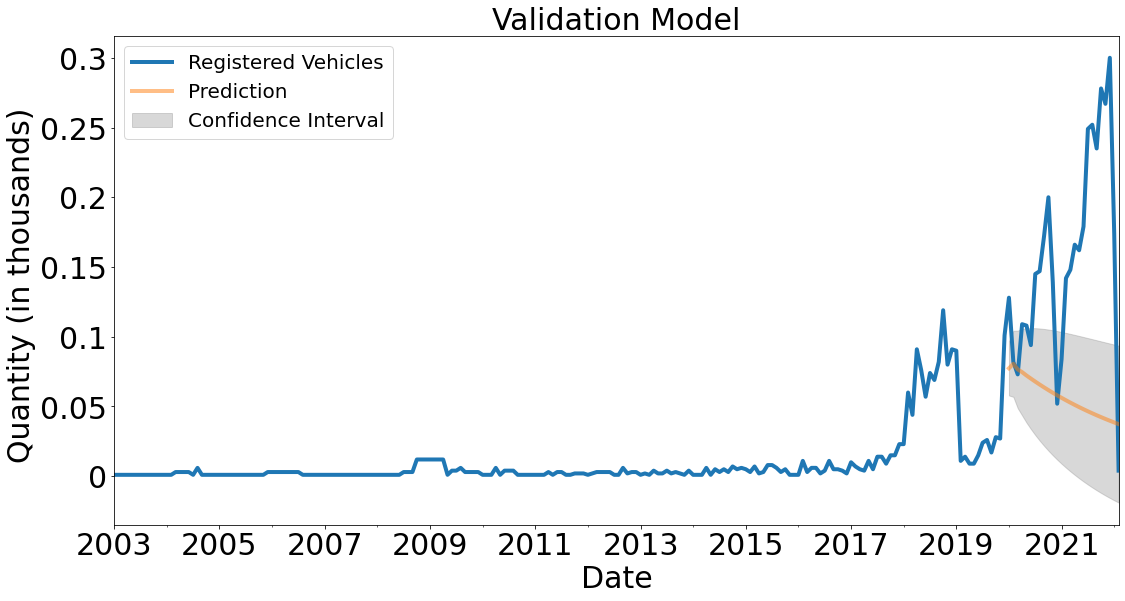

In [22]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()